## * <p style="background-color:#1E90FF; color:white; font-size:50px; font-weight:bold; text-align:center; padding:15px; border-radius:10px;">  Waste Classification </p>
<p style="color:#FF8C00; font-size:30px; font-weight:bold; text-align:center;"> 🌟 Leveraging Transfer Learning for Environmental Impact</p>


<p style="background-color:#DAA520; color:white; font-size:40px; font-weight:bold; text-align:center; padding:15px; border-radius:10px;"> ✨ Let’s get started! 🚀</p>

<a id="setup-initialization"></a>
## <p style="background-color:#FF4500; color:white; font-size:40px; font-weight:bold; text-align:center; padding:10px; border-radius:10px;"> 🔧 Step 1 | Setup & Initialization </p>
📌 Loading essential libraries for data handling, deep learning, and visualization.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

<a id="dataset-analysis"></a>
## <p style="background-color:#FFD700; color:white; font-size:40px; font-weight:bold; text-align:center; padding:10px; border-radius:10px;"> 🔍 Step 2 | Dataset Analysis </p>
📂 Understanding the dataset structure, image distribution, and class balance.

In [2]:
import os
from PIL import Image

# Define dataset paths
dataset_paths = [
    "/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset", 
    "/kaggle/input/extras"
]

# Set to store unique dimensions
all_dimensions_set = set()

# Iterate over both datasets
for dataset_path in dataset_paths:
    if not os.path.exists(dataset_path):
        print(f"Warning: {dataset_path} does not exist.")
        continue

    for garbage_type in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, garbage_type)

        if os.path.isdir(folder_path):
            image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg', 'png'))]
            print(f"{garbage_type} folder contains {len(image_files)} images.")

            for image_file in image_files:
                image_path = os.path.join(folder_path, image_file)
                try:
                    with Image.open(image_path) as img:
                        img = img.convert("RGB")  # Convert to RGB
                        img = img.resize((224, 224))  # Resize to 224x224
                        all_dimensions_set.add((img.width, img.height, len(img.getbands())))
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

# Print unique dimensions
print("\nUnique image dimensions found in the dataset:")
for dim in all_dimensions_set:
    print(dim)

# Check if all images have the same dimensions
if len(all_dimensions_set) == 1:
    width, height, channels = all_dimensions_set.pop()
    print(f"\n✅ All images are standardized to {width}x{height} with {channels} color channels.")
else:
    print("\n⚠️ The dataset still contains images with varying dimensions or color channels.")


metal folder contains 410 images.
glass folder contains 501 images.
paper folder contains 594 images.
trash folder contains 137 images.
cardboard folder contains 403 images.
plastic folder contains 482 images.
biological folder contains 534 images.
battery folder contains 507 images.
shoes folder contains 601 images.
clothes folder contains 522 images.

Unique image dimensions found in the dataset:
(224, 224, 3)

✅ All images are standardized to 224x224 with 3 color channels.


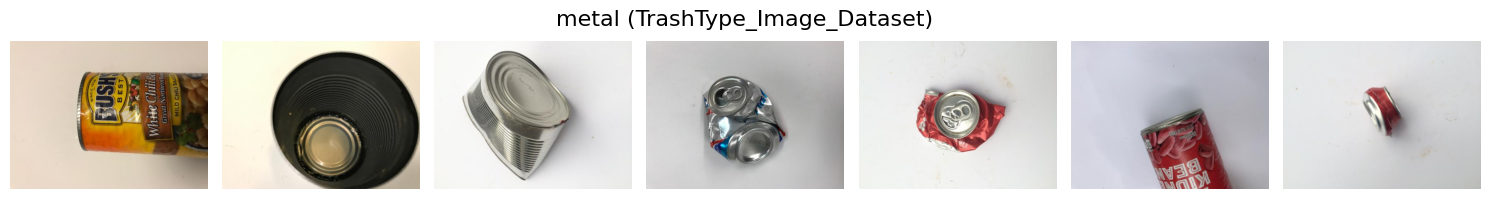

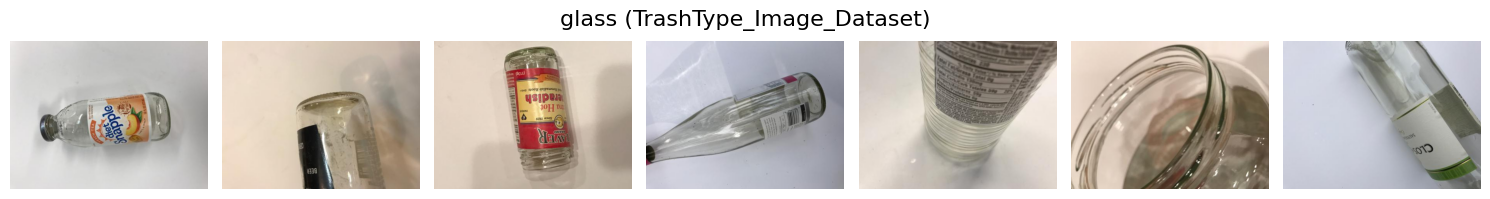

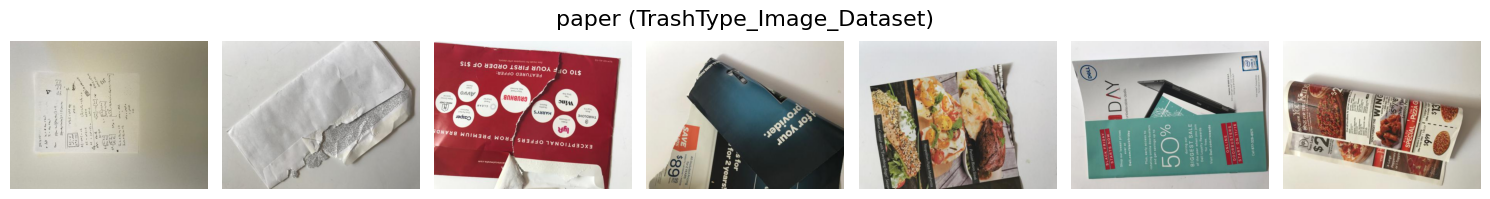

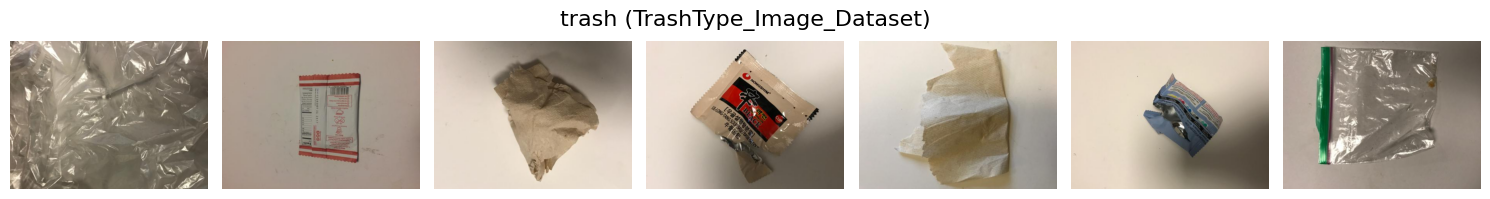

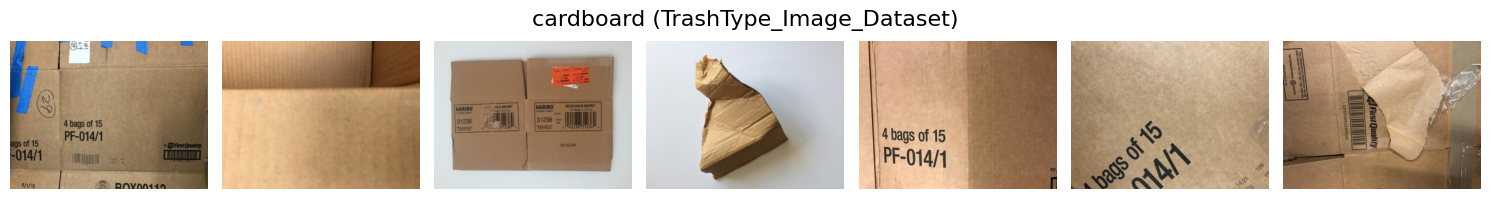

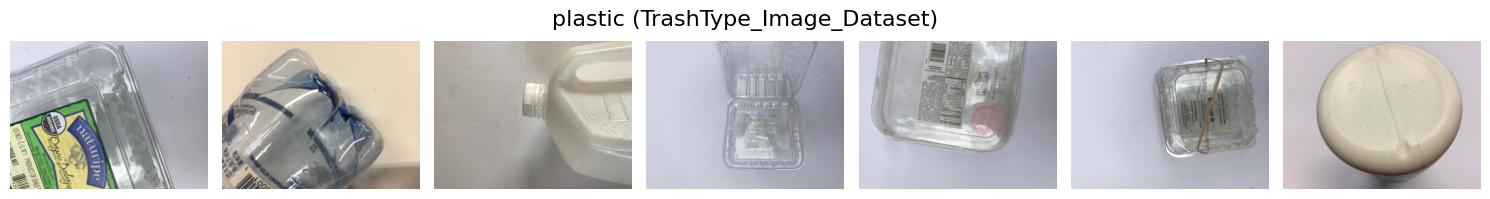

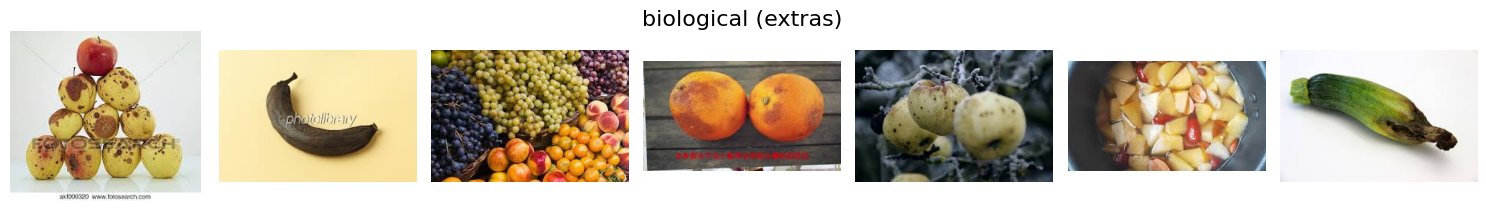

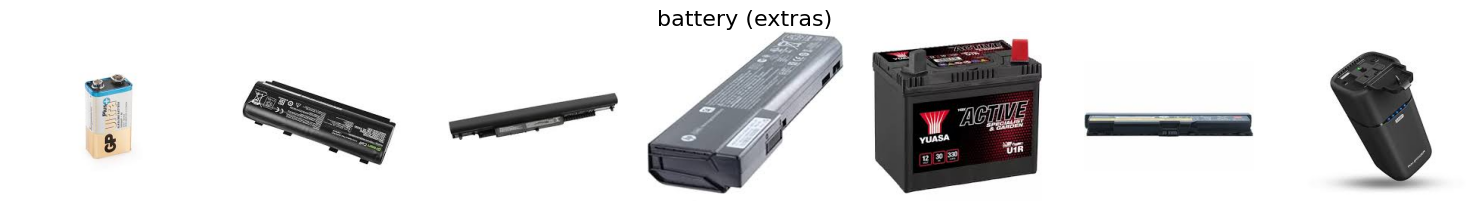

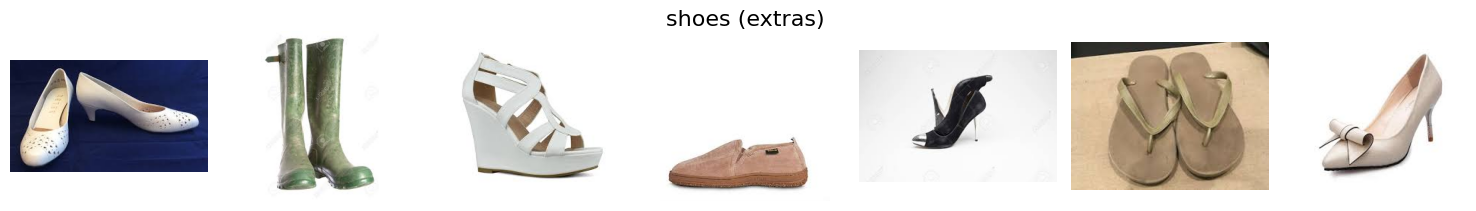

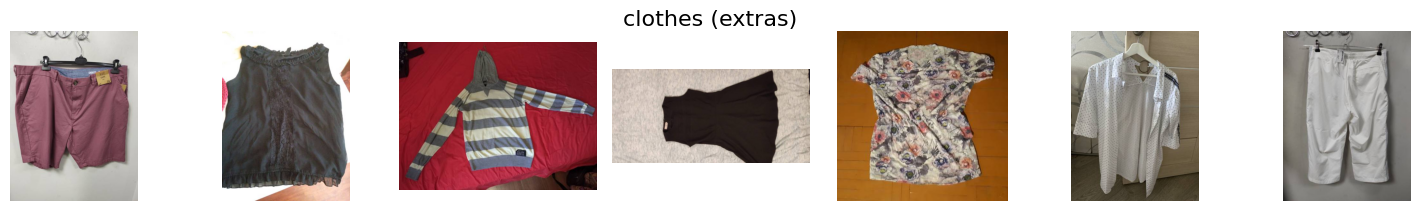

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Iterate over both datasets to display images
for dataset_path in dataset_paths:
    if not os.path.exists(dataset_path):
        print(f"Warning: {dataset_path} does not exist.")
        continue

    for garbage_type in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, garbage_type)

        if os.path.isdir(folder_path):
            image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg', 'png'))]

            if not image_files:
                print(f"Skipping empty folder: {garbage_type}")
                continue

            # Select up to 7 images
            image_files = image_files[:min(7, len(image_files))]

            # Set up subplots dynamically
            fig, axs = plt.subplots(1, len(image_files), figsize=(15, 2))

            for i, image_file in enumerate(image_files):
                image_path = os.path.join(folder_path, image_file)
                with Image.open(image_path) as img:
                    axs[i].imshow(img)
                    axs[i].axis('off')

            plt.tight_layout()
            fig.suptitle(f"{garbage_type} ({os.path.basename(dataset_path)})", fontsize=16, y=1.03)
            plt.show()


🔍 Total images in dataset: 4691
📂 Number of classes: 10

📊 Class Distribution:
 label
shoes         601
paper         594
biological    534
clothes       522
battery       507
glass         501
plastic       482
metal         410
cardboard     403
trash         137
Name: count, dtype: int64
⚠️ Removed 5 corrupt/non-RGB images.


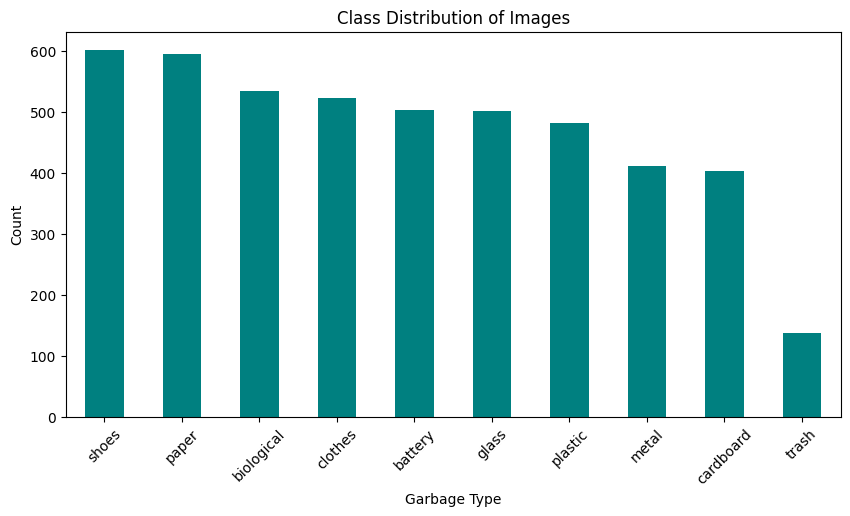

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import Counter

# ✅ Define dataset paths
dataset_paths = [
    "/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset",
    "/kaggle/input/extras"
]

# ✅ Collect image paths & labels
data = [
    (os.path.join(dataset_path, garbage_type, file), garbage_type)
    for dataset_path in dataset_paths if os.path.exists(dataset_path)  # Ensure dataset exists
    for garbage_type in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, garbage_type))  
    for file in os.listdir(os.path.join(dataset_path, garbage_type))
    if file.lower().endswith(('jpg', 'jpeg', 'png'))  # Ensure valid image formats
]

# ✅ Convert to DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# ✅ Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# ✅ Dataset Summary
print(f"🔍 Total images in dataset: {len(df)}")
print(f"📂 Number of classes: {df['label'].nunique()}\n")
print("📊 Class Distribution:\n", df['label'].value_counts())

# ✅ Detect Duplicate Images
duplicate_counts = df['filepath'].duplicated().sum()
if duplicate_counts > 0:
    print(f"⚠️ Warning: Found {duplicate_counts} duplicate images!")
    df = df.drop_duplicates(subset=['filepath']).reset_index(drop=True)

# ✅ Check for Corrupt or Non-RGB Images
invalid_images = []
for i, row in df.iterrows():
    try:
        with Image.open(row['filepath']) as img:
            if img.mode != "RGB":  # Ensure all images are RGB
                invalid_images.append(row['filepath'])
    except Exception as e:
        print(f"❌ Corrupt Image: {row['filepath']} | Error: {e}")
        invalid_images.append(row['filepath'])

# ✅ Remove invalid images
df = df[~df['filepath'].isin(invalid_images)].reset_index(drop=True)
if invalid_images:
    print(f"⚠️ Removed {len(invalid_images)} corrupt/non-RGB images.")

# ✅ Class Distribution Plot
plt.figure(figsize=(10, 5))
df['label'].value_counts().plot(kind='bar', color='teal')
plt.xlabel("Garbage Type")
plt.ylabel("Count")
plt.title("Class Distribution of Images")
plt.xticks(rotation=45)
plt.show()


<a id="data-preprocessing"></a>
## <p style="background-color:#32CD32; color:white; font-size:40px; font-weight:bold; text-align:center; padding:10px; border-radius:10px;"> 🛠️ Step 3 | Data Preprocessing </p> 



In [5]:
# Splitting dataset into train (80%), validation (10%), and test (10%) with stratification
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")
print(f"Number of images in the test set: {len(test_df)}")

Number of images in the training set: 3748
Number of images in the validation set: 469
Number of images in the test set: 469


In [6]:
# ✅ Compute Class Distributions
def compute_distribution(df, dataset_name):
    return df['label'].value_counts(normalize=True).sort_index() * 100

overall_distribution = compute_distribution(df, "Overall Dataset")
train_distribution = compute_distribution(train_df, "Train Set")
val_distribution = compute_distribution(val_df, "Validation Set")
test_distribution = compute_distribution(test_df, "Test Set")

# ✅ Print Distributions
print("📊 Class Distribution (%):")
print("\n🔹 Overall Dataset:\n", overall_distribution.round(2))
print("\n🔹 Training Set:\n", train_distribution.round(2))
print("\n🔹 Validation Set:\n", val_distribution.round(2))
print("\n🔹 Test Set:\n", test_distribution.round(2))


📊 Class Distribution (%):

🔹 Overall Dataset:
 label
battery       10.71
biological    11.40
cardboard      8.60
clothes       11.14
glass         10.69
metal          8.75
paper         12.68
plastic       10.29
shoes         12.83
trash          2.92
Name: proportion, dtype: float64

🔹 Training Set:
 label
battery       10.70
biological    11.39
cardboard      8.59
clothes       11.13
glass         10.70
metal          8.75
paper         12.67
plastic       10.30
shoes         12.83
trash          2.93
Name: proportion, dtype: float64

🔹 Validation Set:
 label
battery       10.87
biological    11.51
cardboard      8.53
clothes       11.09
glass         10.66
metal          8.74
paper         12.58
plastic       10.23
shoes         12.79
trash          2.99
Name: proportion, dtype: float64

🔹 Test Set:
 label
battery       10.66
biological    11.30
cardboard      8.74
clothes       11.30
glass         10.66
metal          8.74
paper         12.79
plastic       10.23
shoes         12.7

<a id="data-augmentation"></a>
## <p style="background-color:#FF69B4; color:white; font-size:40px; font-weight:bold; text-align:center; padding:10px; border-radius:10px;"> 🎨 Step 5 | Data Augmentation & Preprocessing </p>
🖼️ Applying transformations to improve model generalization.

<a id="class-weighting"></a>
## <p style="background-color:#00CED1; color:white; font-size:40px; font-weight:bold; text-align:center; padding:10px; border-radius:10px;"> ⚖️ Step 6 | Class Weight Computation </p>
📊 Handling class imbalance by computing appropriate weights.

<a id="model-training"></a>
## <p style="background-color:#DC143C; color:white; font-size:40px; font-weight:bold; text-align:center; padding:10px; border-radius:10px;"> 🏋️‍♂️ Step 7 | Model Training </p>
🔥 Training the ResNet50 model with fine-tuning and monitoring performance.



<a id="results-evaluation"></a>
## <p style="background-color:#228B22; color:white; font-size:40px; font-weight:bold; text-align:center; padding:10px; border-radius:10px;"> 📈 Step 8 | Results & Evaluation  <p>📉 Assessing model accuracy, loss curves, and generating a confusion matrix.</p>

## 📌 1. Plot Training Curves

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.colors import LinearSegmentedColormap
import requests
from io import BytesIO
from PIL import Image

def plot_learning_curves(history, start_epoch=1):
    df = pd.DataFrame(history.history)
    df = df.iloc[start_epoch - 1:].reset_index(drop=True)  # Fix index alignment

    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    plt.figure(figsize=(15, 6))

    # Loss Curve
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()




## 📌 2. Classification Report & Confusion Matrix


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

class_labels = list(test_generator.class_indices.keys())

def evaluate_model_performance_simple(model, test_generator, class_labels):
    """
    Evaluates the model, prints test accuracy, classification report, 
    and plots a simple confusion matrix.
    """
    true_labels = test_generator.classes  # True class indices

    # Get Model Predictions
    predictions = model.predict(test_generator, steps=len(test_generator))
    predicted_labels = np.argmax(predictions, axis=1)  

    # Compute Test Accuracy
    test_accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%\n")

    # Print Classification Report
    print(classification_report(true_labels, predicted_labels, target_names=class_labels))

    # Compute Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()




## 📌 3. Grad-CAM Visualization



In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import random

def get_last_conv_layer(model):
    """Finds the last convolutional layer of a given model."""
    for layer in reversed(model.layers):
        if 'conv' in layer.name or isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No convolutional layer found in the model.")

def preprocess_image(img_path, target_size):
    """Loads and preprocesses an image for model prediction."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.imagenet_utils.preprocess_input(img_array)
    return img_array

def generate_grad_cam(model, img_paths, class_labels, layer_name=None):
    """
    Generates Grad-CAM heatmaps for multiple images, generalized for any CNN model.
    
    Parameters:
    - model: Trained CNN model.
    - img_paths: List of image file paths.
    - class_labels: List of class names corresponding to indices.
    - layer_name: Layer to extract feature maps from (default: last convolutional layer).
    """
    # Determine the last convolutional layer dynamically if not provided
    if layer_name is None:
        layer_name = get_last_conv_layer(model)

    # Get the input image size from the model
    input_size = model.input.shape[1:3]
    
    num_images = len(img_paths)
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))  

    for idx, img_path in enumerate(img_paths):
        # Load and preprocess the image
        img_array = preprocess_image(img_path, target_size=input_size)

        # Get model predictions
        preds = model.predict(img_array)
        class_index = np.argmax(preds)
        confidence = preds[0][class_index] * 100
        predicted_label = class_labels[class_index]
        print(f"Image {idx+1}: {predicted_label} ({confidence:.2f}%)")

        # Define a model that outputs feature maps and predictions
        grad_model = Model([model.input], [model.get_layer(layer_name).output, model.output])

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            loss = predictions[:, class_index]  # Class activation

        # Compute gradients
        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling

        # Convert tensors to NumPy arrays
        conv_outputs = conv_outputs[0].numpy()
        pooled_grads = pooled_grads.numpy()

        # Compute weighted feature map
        heatmap = np.mean(conv_outputs * pooled_grads, axis=-1)
        heatmap = np.maximum(heatmap, 0)  # ReLU (Remove negative values)

        # Normalize heatmap
        if np.max(heatmap) > 0:
            heatmap /= np.max(heatmap)

        # Load original image and resize heatmap
        img_orig = cv2.imread(img_path)
        img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
        heatmap = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))

        # Convert heatmap to color map
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

        # Overlay heatmap on original image
        overlayed_img = cv2.addWeighted(img_orig, 0.6, heatmap_colored, 0.4, 0)

        # Plot results
        axes[idx, 0].imshow(img_orig)
        axes[idx, 0].set_title(f"Original: {predicted_label}")
        axes[idx, 0].axis("off")

        axes[idx, 1].imshow(heatmap, cmap='jet')
        axes[idx, 1].set_title("Grad-CAM Heatmap")
        axes[idx, 1].axis("off")

        axes[idx, 2].imshow(overlayed_img)
        axes[idx, 2].set_title(f"Overlayed Heatmap\n({confidence:.2f}%)")
        axes[idx, 2].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
# Select random test images
num_images_to_display = 5
random_test_images = random.sample(list(test_df['filepath']), num_images_to_display)

# Generate Grad-CAM for any model (e.g., ResNet, EfficientNet, DenseNet)
generate_grad_cam(transfer_resnet50_model, random_test_images, class_labels)


## 📌 4. Random Test Predictions with Confidence



In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_random_predictions(test_generator, model, class_labels, num_samples=10):
    """
    Selects random images from the test set, predicts them, and visualizes results with confidence scores.

    Parameters:
    - test_generator: Keras ImageDataGenerator for testing.
    - model: Trained deep learning model.
    - class_labels: List of class names.
    - num_samples: Number of random images to display.
    """
    test_generator.reset()  # Reset generator to start from first batch
    x_all, y_all = [], []

    # Collect all test data
    for _ in range(len(test_generator)):
        x_batch, y_batch = test_generator.next()
        x_all.append(x_batch)
        y_all.append(y_batch)

    # Convert to numpy arrays
    x_all = np.concatenate(x_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)

    # Randomly select images
    random_indices = np.random.choice(len(x_all), size=num_samples, replace=False)
    random_images = x_all[random_indices]
    true_labels = np.argmax(y_all[random_indices], axis=1)

    # Get predictions
    predictions = model.predict(random_images)
    predicted_labels = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1) * 100  # Convert to percentage

    # Plot predictions with confidence scores
    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(random_indices):
        img = (random_images[i] * 255).astype(np.uint8)  # Convert back to 0-255 range
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {class_labels[true_labels[i]]}\n"
                  f"Pred: {class_labels[predicted_labels[i]]}\n"
                  f"Conf: {confidence_scores[i]:.2f}%", fontsize=9)

    plt.tight_layout()
    plt.show()




## 📌 5. Single Image Prediction (URL or Local)


In [15]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

def predict_image(image_source, model, class_labels):
    """
    Predicts the class of an image from a URL or local file path.

    Parameters:
    - image_source (str): URL of the image or local file path.
    - model: Trained deep learning model.
    - class_labels (list): List of class names.

    Returns:
    - predicted_label (str): The predicted class label.
    - confidence_score (float): The confidence score (%) of the prediction.
    """
    try:
        # Load Image from URL or Local File
        if image_source.startswith("http"):  # URL case
            headers = {"User-Agent": "Mozilla/5.0"}
            response = requests.get(image_source, headers=headers, stream=True)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content))
        elif os.path.exists(image_source):  # Local file case
            img = Image.open(image_source)
        else:
            print(f"Error: File not found - {image_source}")
            return None, None

        # Convert Image to RGB (handle PNG transparency issues)
        img = img.convert("RGB")
        img = img.resize((224, 224))

        # Preprocess the Image
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Predict the Class
        predictions = model.predict(img_array)
        predicted_label_index = np.argmax(predictions)
        predicted_label = class_labels[predicted_label_index]
        confidence_score = np.max(predictions) * 100  # Convert to percentage

        # Display Image with Prediction
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence_score:.2f}%", fontsize=12, weight="bold")
        plt.show()

        return predicted_label, confidence_score

    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
        return None, None
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None




# Custom CNN model

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import BatchNormalization

# ✅ Load dataset
dataset_paths = ["/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset", "/kaggle/input/extras"]

data = [
    (os.path.join(dataset_path, garbage_type, file), garbage_type)
    for dataset_path in dataset_paths if os.path.exists(dataset_path)
    for garbage_type in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, garbage_type))  
    for file in os.listdir(os.path.join(dataset_path, garbage_type))
    if file.lower().endswith(('jpg', 'jpeg', 'png'))
]

df = pd.DataFrame(data, columns=['filepath', 'label'])

# ✅ Train-validation-test split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

# ✅ Image Preprocessing & Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,  
    width_shift_range=0.3,  
    height_shift_range=0.3,  
    shear_range=0.3,  
    zoom_range=0.3,  
    horizontal_flip=True,  
    brightness_range=[0.7, 1.3],  # Simulate different lighting conditions
    channel_shift_range=0.2,  # Slight color variations
    rescale=1./255
)


val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col="filepath", y_col="label",
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df, x_col="filepath", y_col="label",
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df, x_col="filepath", y_col="label",
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

# ✅ Compute Class Weights AFTER train_generator to match TensorFlow's mapping
from sklearn.utils.class_weight import compute_class_weight

# Ensure class order matches train_generator
sorted_classes = sorted(train_generator.class_indices, key=train_generator.class_indices.get)

# Map class labels to indices using train_generator's mapping
class_indices = train_generator.class_indices  # Example: {'battery': 0, 'biological': 1, ...}
y_numeric = train_df['label'].map(class_indices)  # Map labels using generator's mapping

# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_numeric), y=y_numeric)

# Convert computed weights to dictionary
class_weights = {class_indices[cls]: weight for cls, weight in zip(sorted_classes, weights)}

print("Final Computed Class Weights:", class_weights)


# ✅ Build the Custom CNN Model
model = Sequential([
    Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout to reduce overfitting
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer
])

# ✅ Compile Model
model.compile(optimizer=Nadam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

# ✅ Define Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)

# ✅ Train Model
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    class_weight=class_weights,  # Apply computed class weights
    callbacks=[reduce_lr, early_stopping]
)

# ✅ Evaluate Model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
# ✅ Run Model Evaluation
plot_learning_curves(history, start_epoch=1)

evaluate_model_performance_simple(model, test_generator, class_labels)


# ✅ Plot Random Test Predictions
plot_random_predictions(test_generator, model, class_labels, num_samples=10)



# EcoDenseNet

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Dropout, BatchNormalization,
    Conv2D, Reshape, Multiply, Activation, Add)
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.activations import deserialize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ✅ Mish Activation Function
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

# Register the Mish activation function
tf.keras.utils.get_custom_objects().update({'mish': mish})

# ✅ Squeeze-and-Excitation (SE) Block
def squeeze_excite_block(input_tensor, ratio=16): # Increased ratio for better compression
    """ Squeeze-and-Excitation (SE) Block for channel-wise feature recalibration. """
    channels = int(input_tensor.shape[-1])
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = Reshape((1, 1, channels))(se)
    return Multiply()([input_tensor, se])

# ✅ CBAM (Convolutional Block Attention Module)
def cbam_block(input_tensor):
    """ CBAM (Channel + Spatial Attention) to enhance feature selection. """

    # Channel Attention
    avg_pool = GlobalAveragePooling2D()(input_tensor)
    max_pool = GlobalMaxPooling2D()(input_tensor)
    dense1 = Dense(input_tensor.shape[-1] // 16, activation='relu') # Increased ratio
    dense2 = Dense(input_tensor.shape[-1], activation='sigmoid')
    channel_attention = Add()([dense2(dense1(avg_pool)), dense2(dense1(max_pool))])

    # Spatial Attention
    avg_pool = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(input_tensor, axis=-1, keepdims=True)
    concat = tf.concat([avg_pool, max_pool], axis=-1)
    spatial_attention = Conv2D(1, (7, 7), padding="same", activation='sigmoid')(concat)

    return Multiply()([input_tensor, channel_attention, spatial_attention])

# ✅ Load DenseNet201 as Base Model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# ✅ Freeze Initial Layers (Fine-tuning Strategy)
for layer in base_model.layers[:70]:
    layer.trainable = False
for layer in base_model.layers[70:]:
    layer.trainable = True

# ✅ Feature Extraction with SE + CBAM
x = base_model.output
x = squeeze_excite_block(x)  # First SE block
x = cbam_block(x)  # First CBAM block

# ✅ Extra Convolutional Layers for Better Feature Learning
x = Conv2D(1024, (3, 3), padding='same', activation=mish)(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)  # Second SE block
x = cbam_block(x)  # Second CBAM block
x = Conv2D(512, (3, 3), padding='same', activation=mish)(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)  # Third SE block
x = cbam_block(x)  # Third CBAM block

# ✅ Classification Head
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation=mish, kernel_regularizer='l2')(x)  # Added L2 regularization
x = Dropout(0.3)(x)
x = Dense(512, activation=mish, kernel_regularizer='l2')(x)  # Added L2 regularization
x = Dropout(0.2)(x)

# ✅ Final Output Layer
x = Dense(10, activation='softmax')(x)  # Adjust classes based on dataset

# ✅ Define the Model
ecodensenet_model = Model(inputs=base_model.input, outputs=x)

# ✅ Compile the Model
ecodensenet_model.compile(
    optimizer=AdamW(learning_rate=0.00003, weight_decay=1e-5),  # Using AdamW
    loss='categorical_crossentropy',
    metrics=['accuracy'])

74836368/74836368 [==============================] - 2s 0us/step


In [8]:
# ✅ Data Preprocessing & Augmentation for DeepWasteNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

train_datagen = ImageDataGenerator(
    rotation_range=40,  #reduced rotation
    width_shift_range=0.1,  #reduced shifts
    height_shift_range=0.1, #reduced shifts
    zoom_range=0.15, #reduced zoom
    horizontal_flip=True,
    vertical_flip=False, #reduced flipping
    shear_range=0.05,
    brightness_range=[0.95, 1.05], #reduced brightness
    channel_shift_range=5, #reduced channel shift
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# ✅ Training & Validation Generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=42,
    shuffle=True
)
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=42,
    shuffle=False
)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=42,
    shuffle=False
)

# ✅ Compute Class Weights (Handles Class Imbalance)
sorted_classes = sorted(train_generator.class_indices, key=train_generator.class_indices.get)
class_indices = train_generator.class_indices
y_numeric = train_df['label'].map(class_indices)
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_numeric), y=y_numeric)
class_weights = {class_indices[cls]: weight for cls, weight in zip(sorted_classes, weights)}


Found 3748 validated image filenames belonging to 10 classes.
Found 469 validated image filenames belonging to 10 classes.
Found 469 validated image filenames belonging to 10 classes.


In [10]:
# ✅ Define Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1) #adjusted params
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1) #adjusted params

# ✅ Train DeepWasteNet
history = ecodensenet_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100, #increased epochs
    validation_data=val_generator,
    validation_steps=len(val_generator),
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
118/118 [==============================] - 181s 627ms/step - loss: 14.6053 - accuracy: 0.6694 - val_loss: 15.4822 - val_accuracy: 0.8806 - lr: 3.0000e-05
Epoch 2/100
118/118 [==============================] - 64s 539ms/step - loss: 13.5654 - accuracy: 0.8661 - val_loss: 14.5166 - val_accuracy: 0.9296 - lr: 3.0000e-05
Epoch 3/100
118/118 [==============================] - 63s 533ms/step - loss: 12.9413 - accuracy: 0.9237 - val_loss: 13.1074 - val_accuracy: 0.9446 - lr: 3.0000e-05
Epoch 4/100
118/118 [==============================] - 64s 539ms/step - loss: 12.4090 - accuracy: 0.9448 - val_loss: 12.1960 - val_accuracy: 0.9531 - lr: 3.0000e-05
Epoch 5/100
118/118 [==============================] - 65s 546ms/step - loss: 11.8584 - accuracy: 0.9629 - val_loss: 11.6245 - val_accuracy: 0.9510 - lr: 3.0000e-05
Epoch 6/100
118/118 [==============================] - 64s 542ms/step - loss: 11.3178 - accuracy: 0.9725 - val_loss: 11.1451 - val_accuracy: 0.9446 - lr: 3.0000e-05
Epoch 7/1

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Dropout, BatchNormalization,
    Conv2D, Reshape, Multiply, Activation, Add)
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.activations import deserialize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ... (Mish, SE, CBAM, Model definition, compilation, data generators, class weights, callbacks remain the same) ...

# ✅ Test Time Augmentation (TTA) Function
def predict_with_tta(model, generator, tta_steps=5):
    """
    Predicts using Test Time Augmentation.

    Args:
        model: Trained Keras model.
        generator: Test data generator.
        tta_steps: Number of augmentation passes.

    Returns:
        A NumPy array of averaged predictions.
    """
    all_predictions = []
    generator.reset()  # Important to reset the generator

    for _ in range(tta_steps):
        predictions = model.predict(generator)
        all_predictions.append(predictions)
        generator.reset()

    averaged_predictions = np.mean(all_predictions, axis=0)
    return averaged_predictions

# ✅ Make Predictions with TTA
tta_predictions = predict_with_tta(ecodensenet_model, test_generator)

# ✅ Process Predictions (Example: Get Predicted Labels)
predicted_labels = np.argmax(tta_predictions, axis=1)

# ✅ Get True Labels from Test Generator
true_labels = test_generator.classes

# ✅ Evaluate Performance (Example: Accuracy)
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy with TTA: {accuracy}")

print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))

15/15 [==============================] - 2s 165ms/step
Test Accuracy with TTA: 0.976545842217484
              precision    recall  f1-score   support

     battery       1.00      0.98      0.99        50
  biological       1.00      1.00      1.00        53
   cardboard       1.00      1.00      1.00        41
     clothes       1.00      1.00      1.00        53
       glass       0.96      0.88      0.92        50
       metal       0.87      0.98      0.92        41
       paper       1.00      0.98      0.99        60
     plastic       0.96      0.96      0.96        48
       shoes       1.00      1.00      1.00        60
       trash       0.93      1.00      0.96        13

    accuracy                           0.98       469
   macro avg       0.97      0.98      0.97       469
weighted avg       0.98      0.98      0.98       469



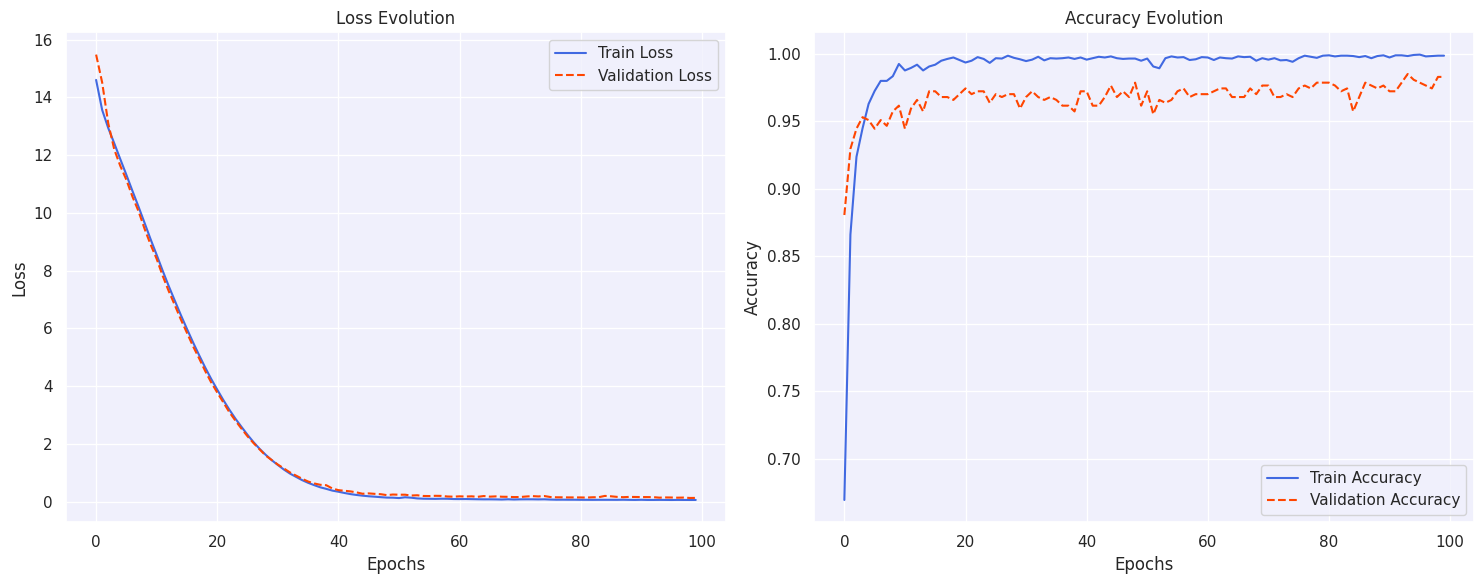

15/15 [==============================] - 2s 166ms/step

Test Accuracy: 97.65%

              precision    recall  f1-score   support

     battery       1.00      0.98      0.99        50
  biological       1.00      1.00      1.00        53
   cardboard       1.00      1.00      1.00        41
     clothes       1.00      1.00      1.00        53
       glass       0.96      0.88      0.92        50
       metal       0.87      0.98      0.92        41
       paper       1.00      0.98      0.99        60
     plastic       0.96      0.96      0.96        48
       shoes       1.00      1.00      1.00        60
       trash       0.93      1.00      0.96        13

    accuracy                           0.98       469
   macro avg       0.97      0.98      0.97       469
weighted avg       0.98      0.98      0.98       469



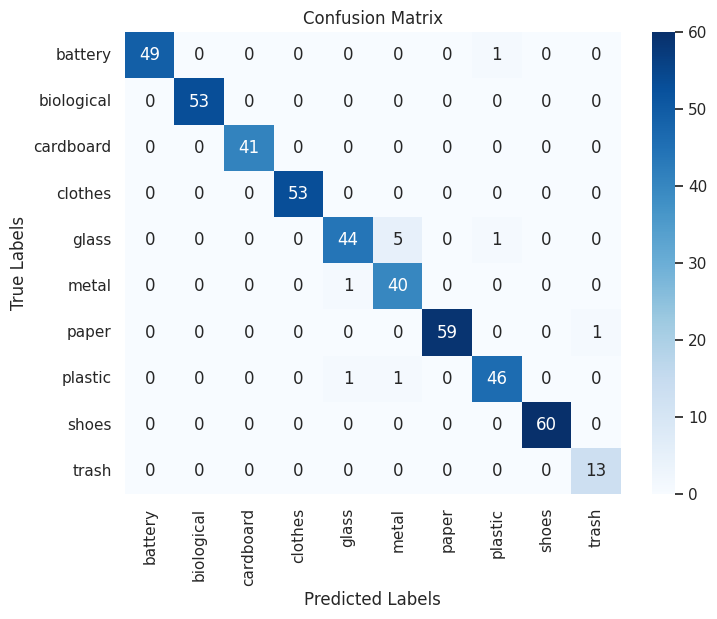

1/1 [==============================] - 7s 7s/step


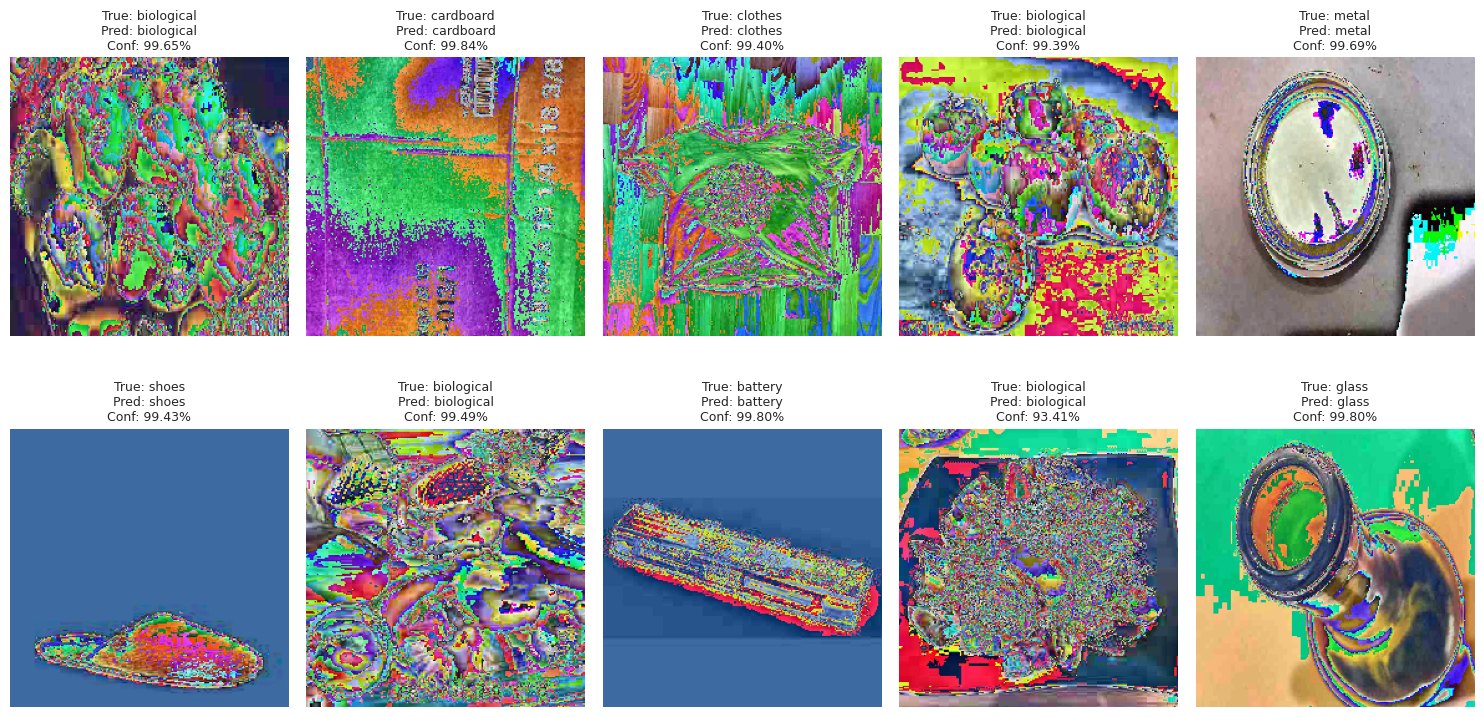

1/1 [==============================] - 2s 2s/step


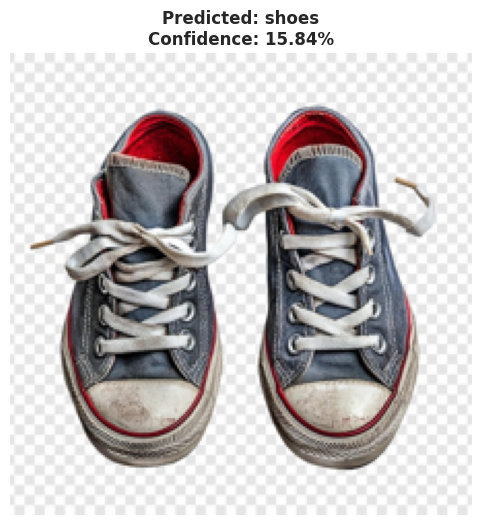

1/1 [==============================] - 0s 41ms/step


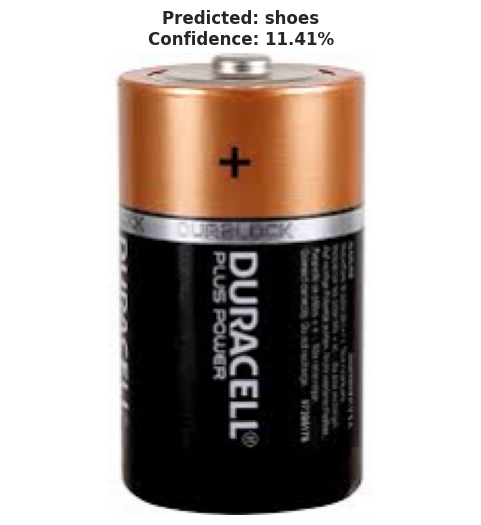

Predicted label: shoes
Confidence score: 11.41%


In [16]:
ecodensenet_model.save("ecodensenet_model.h5")

# ✅ Run Model Evaluation
plot_learning_curves(history, start_epoch=1)

evaluate_model_performance_simple(ecodensenet_model, test_generator, class_labels)

# ✅ Plot Random Test Predictions
plot_random_predictions(test_generator, ecodensenet_model, class_labels, num_samples=10)

# ✅ Predict Image from URL
image_url = "https://img.freepik.com/free-psd/worn-canvas-sneakers-tied-together-nostalgia-fashion-footwear_632498-38837.jpg?ga=GA1.1.640609617.1741138681&semt=ais_hybrid"
predicted_label, confidence = predict_image(image_url, ecodensenet_model, class_labels)

# ✅ Predict Image from Local Dataset
image_path = "/kaggle/input/extras/battery/battery119.jpg"
predicted_label, confidence = predict_image(image_path, ecodensenet_model, class_labels)

if predicted_label:
    print(f"Predicted label: {predicted_label}")
    print(f"Confidence score: {confidence:.2f}%")


# Ecomobilenetv3_model | improved MobileNetV3-Large model

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Advanced Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rotation_range=360,               # Increased rotation range for better invariance
    width_shift_range=0.2,            # Slightly more shift
    height_shift_range=0.2,
    shear_range=0.15,                 # Increased shear for better perspective adaptation
    zoom_range=[0.8, 1.2],            # Allows both zoom in and out
    horizontal_flip=True,
    vertical_flip=True,               # Supports flipping in both directions
    brightness_range=[0.7, 1.3],       # More variation in brightness
    channel_shift_range=20,           # Helps model adjust to different lighting conditions
    fill_mode='nearest',
    preprocessing_function=preprocess_input  # Keeps consistency with MobileNetV3 preprocessing
)

# ✅ Preprocessing for Validation & Test Sets (No Augmentations)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# ✅ Training Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=42,
    shuffle=True
)

# ✅ Validation Generator
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=42,
    shuffle=False
)

# ✅ Test Generator
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=42,
    shuffle=False
)


Found 3748 validated image filenames belonging to 10 classes.
Found 469 validated image filenames belonging to 10 classes.
Found 469 validated image filenames belonging to 10 classes.


In [19]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ✅ Get Class Indices
sorted_classes = sorted(train_generator.class_indices, key=train_generator.class_indices.get)
class_indices = train_generator.class_indices  # Example: {'battery': 0, 'biological': 1, ...}
y_numeric = train_df['label'].map(class_indices)

# ✅ Compute Class Weights
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_numeric), y=y_numeric)

# ✅ Convert to Dictionary
class_weights = {class_indices[cls]: weight for cls, weight in zip(sorted_classes, weights)}

print("Final Computed Class Weights:", class_weights)


Final Computed Class Weights: {0: 0.9346633416458853, 1: 0.877751756440281, 2: 1.163975155279503, 3: 0.8988009592326139, 4: 0.9346633416458853, 5: 1.1426829268292682, 6: 0.7890526315789473, 7: 0.9709844559585492, 8: 0.7792099792099793, 9: 3.4072727272727272}


In [20]:
def poly_focal_loss(alpha=0.25, gamma=2.0, epsilon=0.5):
    def loss(y_true, y_pred):
        # ✅ Fix: Explicitly specify reduction method
        cross_entropy = CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
        
        # Compute poly focal loss
        pt = tf.reduce_sum(y_true * y_pred, axis=-1)
        poly_focal = cross_entropy + epsilon * (1 - pt)
        
        # ✅ Fix: Apply per-batch reduction to avoid shape mismatch
        return tf.reduce_mean(poly_focal)
    
    return loss


# Enable multi-GPU training
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # Load MobileNetV3Large with pre-trained weights
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the initial layers for feature extraction
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Unfreeze deeper layers for fine-tuning
    for layer in base_model.layers[100:]:
        layer.trainable = True

    # Custom SE module improvement (optional)
    def improved_se_block(input_tensor, reduction=16):
        """Implements an improved SE Block with reduced size and increased efficiency."""
        x = GlobalAveragePooling2D()(input_tensor)
        x = Dense(input_tensor.shape[-1] // reduction, activation="relu")(x)
        x = Dense(input_tensor.shape[-1], activation="sigmoid")(x)
        return tf.keras.layers.multiply([input_tensor, x])

    # Build model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(10, activation="softmax")(x)

    ecomobilenetv3_model = Model(inputs=base_model.input, outputs=x)

    # Compile the model
    ecomobilenetv3_model.compile(optimizer=Adam(learning_rate=0.0001),
                              loss=poly_focal_loss(),
                              metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

# Train the model
history = ecomobilenetv3_model.fit(train_generator,
                                steps_per_epoch=len(train_generator),
                                epochs=100,
                                validation_data=val_generator,
                                validation_steps=len(val_generator),
                                class_weight=class_weights,
                                callbacks=[reduce_lr, early_stopping])


12683000/12683000 [==============================] - 1s 0us/step
Epoch 1/100
118/118 [==============================] - 95s 484ms/step - loss: 1.7928 - accuracy: 0.5125 - val_loss: 0.7486 - val_accuracy: 0.7974 - lr: 1.0000e-04
Epoch 2/100
118/118 [==============================] - 57s 486ms/step - loss: 0.8750 - accuracy: 0.7679 - val_loss: 0.4623 - val_accuracy: 0.8785 - lr: 1.0000e-04
Epoch 3/100
118/118 [==============================] - 57s 482ms/step - loss: 0.6580 - accuracy: 0.8247 - val_loss: 0.3617 - val_accuracy: 0.9019 - lr: 1.0000e-04
Epoch 4/100
118/118 [==============================] - 58s 488ms/step - loss: 0.5509 - accuracy: 0.8525 - val_loss: 0.3015 - val_accuracy: 0.9147 - lr: 1.0000e-04
Epoch 5/100
118/118 [==============================] - 57s 485ms/step - loss: 0.4812 - accuracy: 0.8727 - val_loss: 0.2496 - val_accuracy: 0.9403 - lr: 1.0000e-04
Epoch 6/100
118/118 [==============================] - 57s 487ms/step - loss: 0.4027 - accuracy: 0.8914 - val_loss: 0.23

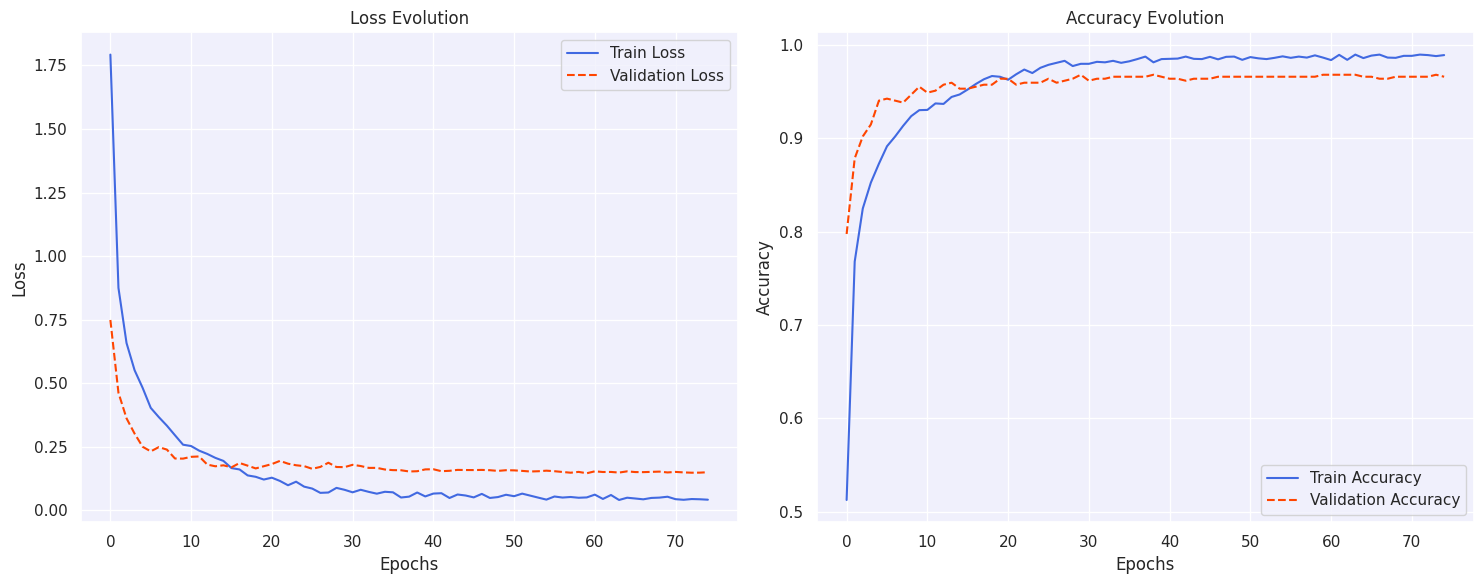

15/15 [==============================] - 4s 96ms/step

Test Accuracy: 97.65%

              precision    recall  f1-score   support

     battery       1.00      0.96      0.98        50
  biological       1.00      1.00      1.00        53
   cardboard       1.00      0.98      0.99        41
     clothes       1.00      1.00      1.00        53
       glass       1.00      0.88      0.94        50
       metal       0.91      1.00      0.95        41
       paper       0.98      0.98      0.98        60
     plastic       0.94      1.00      0.97        48
       shoes       0.97      1.00      0.98        60
       trash       0.92      0.92      0.92        13

    accuracy                           0.98       469
   macro avg       0.97      0.97      0.97       469
weighted avg       0.98      0.98      0.98       469



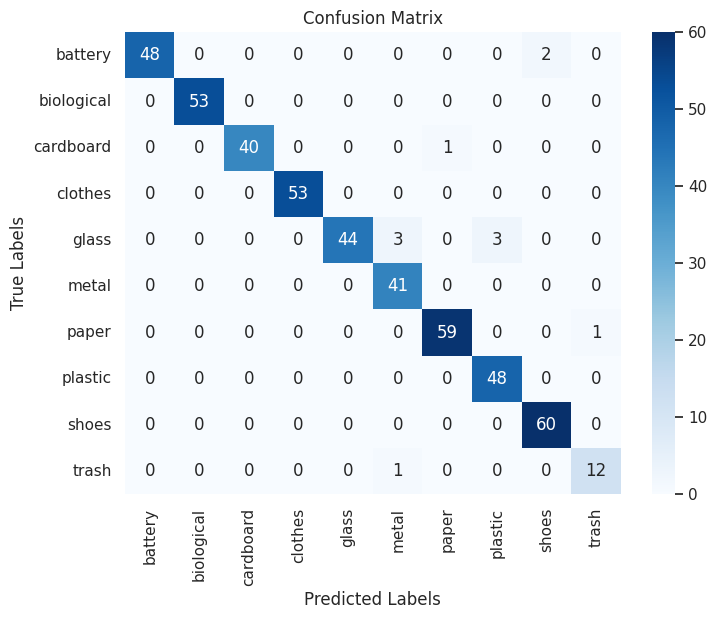

1/1 [==============================] - 3s 3s/step


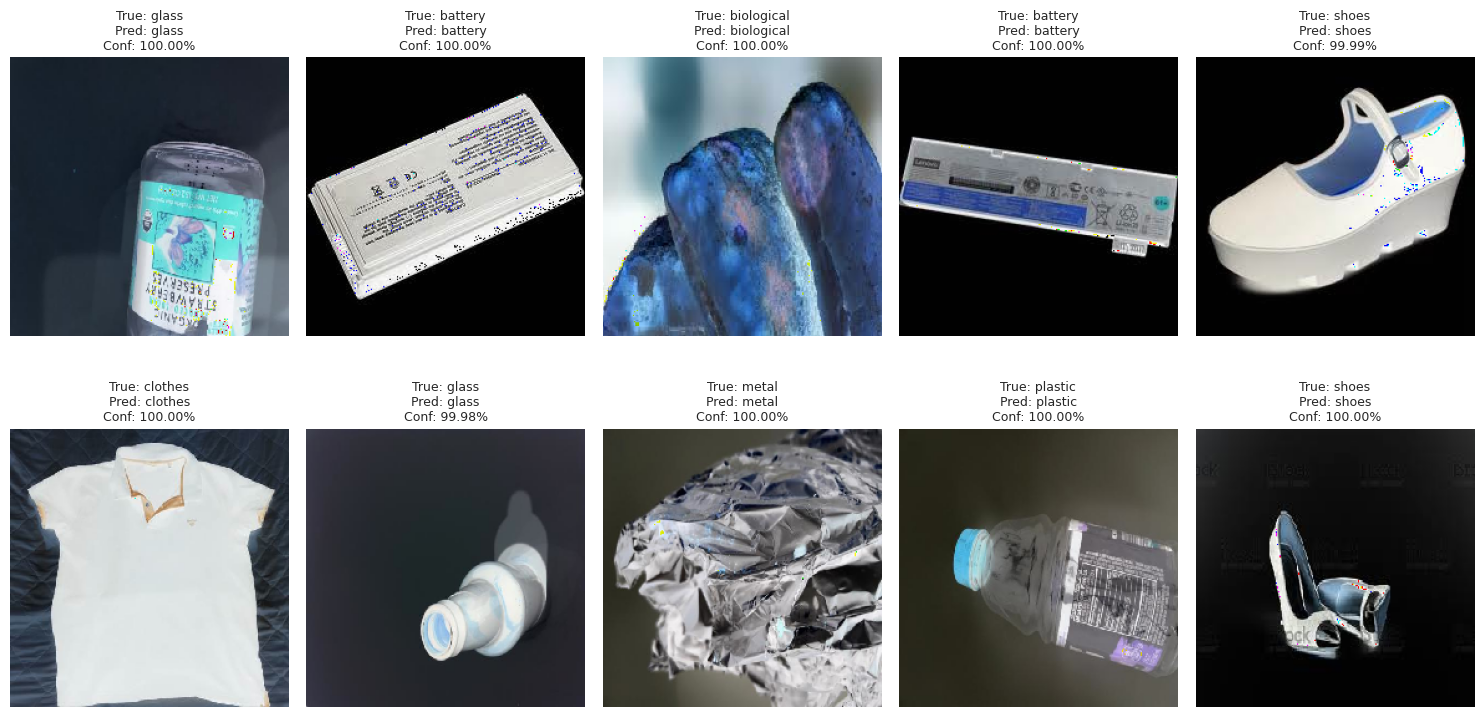

1/1 [==============================] - 1s 775ms/step


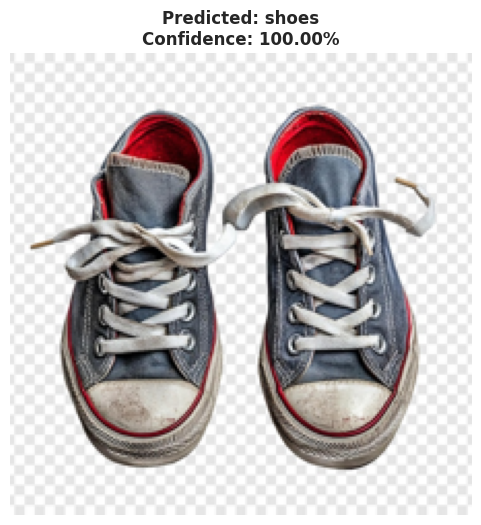

1/1 [==============================] - 0s 126ms/step


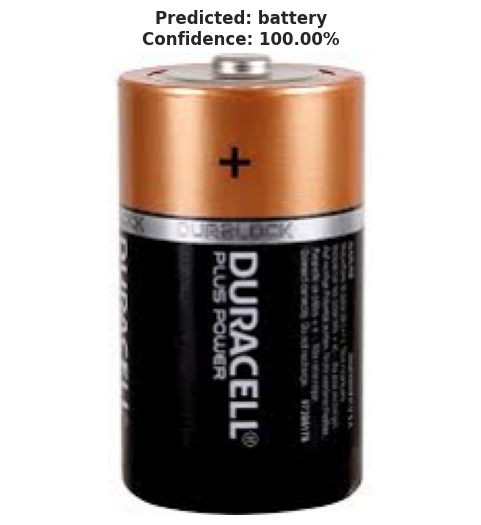

Predicted label: battery
Confidence score: 100.00%


In [21]:
# ✅ Run Model Evaluation
plot_learning_curves(history, start_epoch=1)

evaluate_model_performance_simple(ecomobilenetv3_model, test_generator, class_labels)


# ✅ Plot Random Test Predictions
plot_random_predictions(test_generator, ecomobilenetv3_model, class_labels, num_samples=10)

# ✅ Predict Image from URL
image_url = "https://img.freepik.com/free-psd/worn-canvas-sneakers-tied-together-nostalgia-fashion-footwear_632498-38837.jpg?ga=GA1.1.640609617.1741138681&semt=ais_hybrid"
predicted_label, confidence = predict_image(image_url, ecomobilenetv3_model, class_labels)

# ✅ Predict Image from Local Dataset
image_path = "/kaggle/input/extras/battery/battery119.jpg"
predicted_label, confidence = predict_image(image_path, ecomobilenetv3_model, class_labels)

if predicted_label:
    print(f"Predicted label: {predicted_label}")
    print(f"Confidence score: {confidence:.2f}%")

# Also Trying A Hybrid model of
(ResNet50, EfficientNetV2M, DenseNet201)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet50, efficientnet_v2, densenet

# ✅ Define preprocessing functions
resnet_preprocess = resnet50.preprocess_input
efficientnet_preprocess = efficientnet_v2.preprocess_input
densenet_preprocess = densenet.preprocess_input

# ✅ Optimal ResNet50 Data Generator (Moderate Augmentation)
resnet_train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    rotation_range=45,               # Moderate rotation
    width_shift_range=0.15,          # Moderate horizontal shift
    height_shift_range=0.15,         # Moderate vertical shift
    zoom_range=0.2,                  # Moderate zoom
    horizontal_flip=True,            # Standard flipping
    fill_mode='nearest'
)

# ✅ Optimal EfficientNetV2M Data Generator (Stronger Augmentation)
efficientnet_train_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,
    rotation_range=60,               # Higher rotation tolerance
    width_shift_range=0.2,           # Larger shifts
    height_shift_range=0.2,
    zoom_range=0.3,                  # More aggressive zoom
    horizontal_flip=True,
    vertical_flip=True,              # EfficientNet handles vertical flips well
    brightness_range=[0.8, 1.2],      # Can tolerate brightness variation
    shear_range=0.1,                 # Handles slight distortions
    fill_mode='nearest'
)

# ✅ Optimal DenseNet201 Data Generator (Mild but Effective Augmentation)
densenet_train_datagen = ImageDataGenerator(
    preprocessing_function=densenet_preprocess,
    rotation_range=30,               # Lower rotation to preserve fine details
    width_shift_range=0.1,           # Less aggressive shifts
    height_shift_range=0.1,
    zoom_range=0.15,                 # Limited zoom to avoid distortion
    horizontal_flip=True,
    shear_range=0.05,                # Small shear for robustness
    fill_mode='nearest'
)

# ✅ Validation & Test Generators (Only Normalization)
resnet_val_test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)
efficientnet_val_test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)
densenet_val_test_datagen = ImageDataGenerator(preprocessing_function=densenet_preprocess)

In [23]:
# ✅ Training Generators
resnet_train_generator = resnet_train_datagen.flow_from_dataframe(
    dataframe=train_df, x_col="filepath", y_col="label",
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True, seed=42
)

efficientnet_train_generator = efficientnet_train_datagen.flow_from_dataframe(
    dataframe=train_df, x_col="filepath", y_col="label",
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True, seed=42
)

densenet_train_generator = densenet_train_datagen.flow_from_dataframe(
    dataframe=train_df, x_col="filepath", y_col="label",
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True, seed=42
)

# ✅ Validation Generators
resnet_val_generator = resnet_val_test_datagen.flow_from_dataframe(
    dataframe=val_df, x_col="filepath", y_col="label",
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False, seed=42
)

efficientnet_val_generator = efficientnet_val_test_datagen.flow_from_dataframe(
    dataframe=val_df, x_col="filepath", y_col="label",
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False, seed=42
)

densenet_val_generator = densenet_val_test_datagen.flow_from_dataframe(
    dataframe=val_df, x_col="filepath", y_col="label",
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False, seed=42
)
resnet_test_generator = resnet_val_test_datagen.flow_from_dataframe(
    dataframe=test_df, x_col="filepath", y_col="label",
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False, seed=42
)

efficientnet_test_generator = efficientnet_val_test_datagen.flow_from_dataframe(
    dataframe=test_df, x_col="filepath", y_col="label",
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False, seed=42
)

densenet_test_generator = densenet_val_test_datagen.flow_from_dataframe(
    dataframe=test_df, x_col="filepath", y_col="label",
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False, seed=42
)

Found 3748 validated image filenames belonging to 10 classes.
Found 3748 validated image filenames belonging to 10 classes.
Found 3748 validated image filenames belonging to 10 classes.
Found 469 validated image filenames belonging to 10 classes.
Found 469 validated image filenames belonging to 10 classes.
Found 469 validated image filenames belonging to 10 classes.
Found 469 validated image filenames belonging to 10 classes.
Found 469 validated image filenames belonging to 10 classes.
Found 469 validated image filenames belonging to 10 classes.


In [24]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetV2M, DenseNet201
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, concatenate, BatchNormalization, LayerNormalization
from tensorflow.keras.models import Model

# ✅ Enable Multi-GPU Training
strategy = tf.distribute.MirroredStrategy()  # Automatically distributes computation across available GPUs

print(f"Number of GPUs Available: {strategy.num_replicas_in_sync}")

with strategy.scope():  # Wrap model creation inside strategy scope
    # Define input shape
    input_shape = (224, 224, 3)
    num_classes = len(resnet_train_generator.class_indices)

    # ✅ Separate input layers
    resnet_input = Input(shape=input_shape, name="resnet_input")
    efficientnet_input = Input(shape=input_shape, name="efficientnet_input")
    densenet_input = Input(shape=input_shape, name="densenet_input")

    # ✅ Load pre-trained models (without top layers)
    resnet50 = ResNet50(weights="imagenet", include_top=False, input_tensor=resnet_input)
    efficientnet = EfficientNetV2M(weights="imagenet", include_top=False, input_tensor=efficientnet_input)
    densenet = DenseNet201(weights="imagenet", include_top=False, input_tensor=densenet_input)

    # ✅ Ensure unique layer names to prevent duplication errors
    for model in [resnet50, efficientnet, densenet]:
        for layer in model.layers:
            layer._name = f"{model.name}_{layer.name}"

    # ✅ Fine-Tuning: Freeze early layers, train deeper layers dynamically
    for model in [resnet50, efficientnet, densenet]:
        total_layers = len(model.layers)
        fine_tune_at = int(total_layers * 0.6)  # Fine-tune top 40% layers

        for layer in model.layers[:fine_tune_at]:  
            layer.trainable = False  # Freeze earlier layers
        for layer in model.layers[fine_tune_at:]:  
            layer.trainable = True  # Fine-tune deeper layers

    # ✅ Feature Extraction with Layer Normalization
    resnet_out = GlobalAveragePooling2D(name="resnet_avg_pool")(resnet50.output)
    efficientnet_out = GlobalAveragePooling2D(name="efficientnet_avg_pool")(efficientnet.output)
    densenet_out = GlobalAveragePooling2D(name="densenet_avg_pool")(densenet.output)

    resnet_weighted = tf.keras.layers.Lambda(lambda x: x * 0.3)(resnet_out)
    efficientnet_weighted = tf.keras.layers.Lambda(lambda x: x * 0.4)(efficientnet_out)
    densenet_weighted = tf.keras.layers.Lambda(lambda x: x * 0.3)(densenet_out)
    
    merged = concatenate([resnet_weighted, efficientnet_weighted, densenet_weighted], name="merged_features")

    # ✅ Fully Connected Layers (Optimized)
    x = Dense(1024, activation=None, name="dense_1")(merged)
    x = BatchNormalization(name="batch_norm_1")(x)
    x = tf.keras.activations.relu(x)
    x = Dropout(0.4, name="dropout_1")(x)

    x = Dense(512, activation=None, name="dense_2")(x)
    x = BatchNormalization(name="batch_norm_2")(x)
    x = tf.keras.activations.relu(x)
    x = Dropout(0.3, name="dropout_2")(x)

    x = Dense(256, activation=None, name="dense_3")(x)
    x = BatchNormalization(name="batch_norm_3")(x)
    x = tf.keras.activations.relu(x)
    x = Dropout(0.3, name="dropout_3")(x)

    output = Dense(num_classes, activation="softmax", name="output_layer")(x)

    # ✅ Define Model with Multiple Inputs
    hybrid_model = Model(inputs=[resnet_input, efficientnet_input, densenet_input], outputs=output, name="hybrid_model")



    # ✅ Compile Model inside strategy scope
    hybrid_model.compile(optimizer=Adam(learning_rate=0.0001),  
                           loss='categorical_crossentropy', 
                           metrics=['accuracy'])

# ✅ Summary
print(f"Total parameters: {hybrid_model.count_params():,}")

Number of GPUs Available: 2
214201816/214201816 [==============================] - 6s 0us/step
Total parameters: 101,100,926


In [25]:
import numpy as np
from tensorflow.keras.utils import Sequence

class MultiInputGenerator(Sequence):
    def __init__(self, resnet_gen, efficientnet_gen, densenet_gen, shuffle=True):
        self.resnet_gen = resnet_gen  
        self.efficientnet_gen = efficientnet_gen  
        self.densenet_gen = densenet_gen  
        self.shuffle = shuffle
        self.indexes = np.arange(self.__len__())  # Track indexes for shuffling
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        """Return the minimum batch count across all generators."""
        return min(len(self.resnet_gen), len(self.efficientnet_gen), len(self.densenet_gen))

    def __getitem__(self, index):
        """Fetches batch from all three generators."""
        shuffled_index = self.indexes[index]  # Get the shuffled index

        resnet_x, batch_y = self.resnet_gen[shuffled_index]
        efficientnet_x, _ = self.efficientnet_gen[shuffled_index]  
        densenet_x, _ = self.densenet_gen[shuffled_index]

        # Ensure batch sizes match
        min_batch_size = min(resnet_x.shape[0], efficientnet_x.shape[0], densenet_x.shape[0])
        resnet_x, efficientnet_x, densenet_x = (
            resnet_x[:min_batch_size],
            efficientnet_x[:min_batch_size],
            densenet_x[:min_batch_size],
        )
        batch_y = batch_y[:min_batch_size]

        return [resnet_x, efficientnet_x, densenet_x], batch_y

    def on_epoch_end(self):
        """Shuffle data at the end of each epoch if enabled."""
        self.indexes = np.arange(self.__len__())  # Recalculate in case dataset size changes
        if self.shuffle:
            np.random.shuffle(self.indexes)

# ✅ Wrap train, validation, and test generators
train_multi_input_generator = MultiInputGenerator(
    resnet_train_generator, efficientnet_train_generator, densenet_train_generator, shuffle=True
)

val_multi_input_generator = MultiInputGenerator(
    resnet_val_generator, efficientnet_val_generator, densenet_val_generator, shuffle=False
)

test_multi_input_generator = MultiInputGenerator(
    resnet_test_generator, efficientnet_test_generator, densenet_test_generator, shuffle=False
)

In [26]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy

# ✅ Enable Mixed Precision Training (Faster Training)
set_global_policy('mixed_float16')

# ✅ Define Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1
)


# ✅ Train the Model
history = hybrid_model.fit(
    train_multi_input_generator,  
    epochs=100,
    validation_data=val_multi_input_generator,  
    class_weight=class_weights,  
    callbacks=[reduce_lr, early_stopping]  # ✅ Save Best Model
)

Epoch 1/100


2025-03-30 18:08:05.623672: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inhybrid_model/efficientnetv2-m_block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


118/118 [==============================] - 448s 2s/step - loss: 1.4126 - accuracy: 0.5611 - val_loss: 0.9366 - val_accuracy: 0.8891 - lr: 1.0000e-04
Epoch 2/100
118/118 [==============================] - 173s 1s/step - loss: 0.6430 - accuracy: 0.8188 - val_loss: 0.3578 - val_accuracy: 0.9360 - lr: 1.0000e-04
Epoch 3/100
118/118 [==============================] - 174s 1s/step - loss: 0.4618 - accuracy: 0.8749 - val_loss: 0.2135 - val_accuracy: 0.9403 - lr: 1.0000e-04
Epoch 4/100
118/118 [==============================] - 172s 1s/step - loss: 0.3695 - accuracy: 0.8967 - val_loss: 0.1695 - val_accuracy: 0.9510 - lr: 1.0000e-04
Epoch 5/100
118/118 [==============================] - 173s 1s/step - loss: 0.2554 - accuracy: 0.9317 - val_loss: 0.1416 - val_accuracy: 0.9552 - lr: 1.0000e-04
Epoch 6/100
118/118 [==============================] - 172s 1s/step - loss: 0.2156 - accuracy: 0.9424 - val_loss: 0.1540 - val_accuracy: 0.9552 - lr: 1.0000e-04
Epoch 7/100
118/118 [=========================

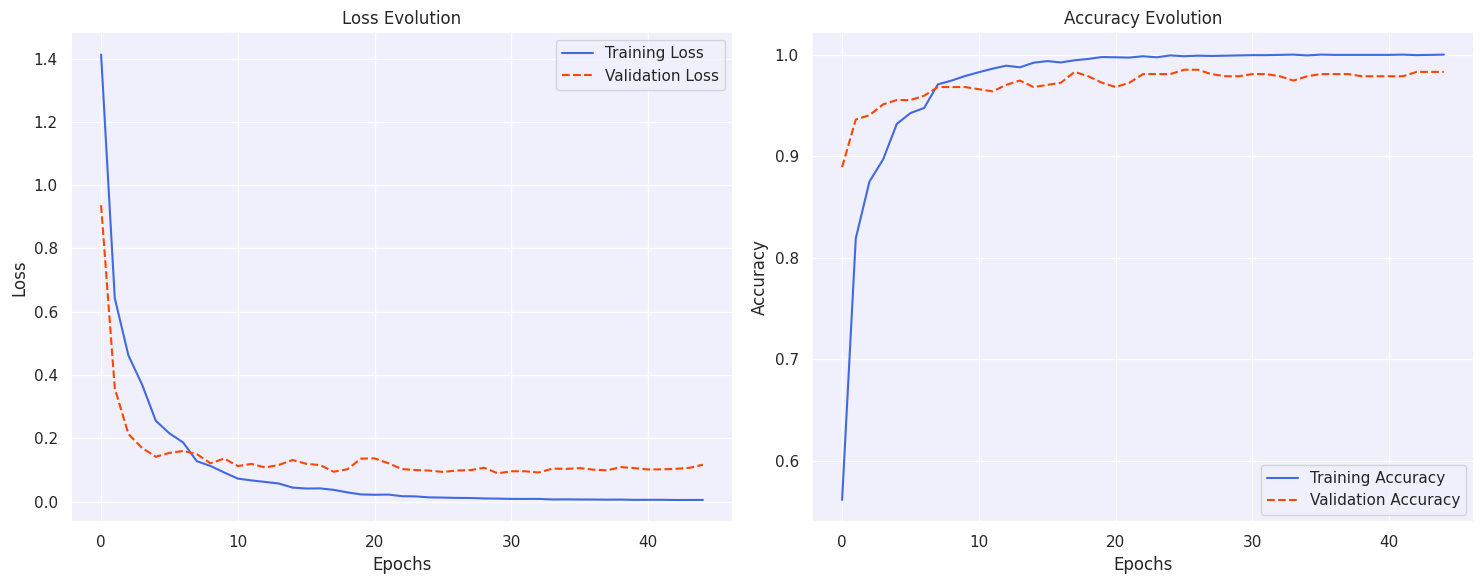

Plot saved as: training_history.png


In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
def plot_training_history(history, start_epoch=1, save_path="training_history.png"):
    df = pd.DataFrame(history.history)
    df = df.iloc[start_epoch - 1:].reset_index(drop=True)  # Skip initial epochs if needed

    sns.set(style='darkgrid', rc={'axes.facecolor': '#f0f0fc'})

    plt.figure(figsize=(15, 6))

    # 🔹 Loss Curve
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='Training Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Evolution")
    plt.legend()

    # 🔹 Accuracy Curve
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='Training Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Evolution")
    plt.legend()

    plt.tight_layout()
    
    # ✅ Save the figure
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    
    print(f"Plot saved as: {save_path}")

# ✅ Call the function
plot_training_history(history, save_path="training_history.png")

15/15 [==============================] - 5s 311ms/step - loss: 0.0841 - accuracy: 0.9787

🔥 Test Accuracy: 97.87%
1/1 [==============================] - 23s 23s/step

📌 Classification Report:
               precision    recall  f1-score   support

     battery       1.00      0.98      0.99        50
  biological       1.00      1.00      1.00        53
   cardboard       0.97      0.95      0.96        41
     clothes       1.00      1.00      1.00        53
       glass       0.98      0.92      0.95        50
       metal       0.95      0.98      0.96        41
       paper       0.97      0.98      0.98        60
     plastic       0.94      1.00      0.97        48
       shoes       1.00      1.00      1.00        60
       trash       0.92      0.92      0.92        13

    accuracy                           0.98       469
   macro avg       0.97      0.97      0.97       469
weighted avg       0.98      0.98      0.98       469



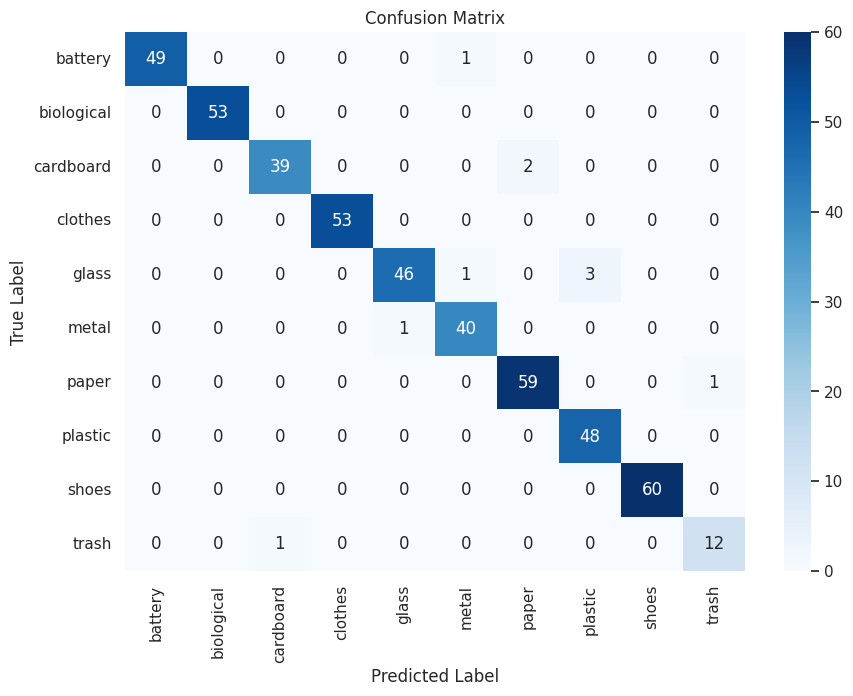

In [28]:
# ✅ Evaluate Model on Test Set
test_loss, test_accuracy = hybrid_model.evaluate(test_multi_input_generator, verbose=1)
print(f"\n🔥 Test Accuracy: {test_accuracy * 100:.2f}%")

# ✅ Get Predictions Efficiently
y_true = []
y_pred = []

for i in range(len(test_multi_input_generator)):
    (X_resnet, X_efficientnet, X_densenet), y_batch = test_multi_input_generator[i]  # Extract correctly
    preds = hybrid_model.predict([X_resnet, X_efficientnet, X_densenet])  # ✅ Proper input
    y_true.extend(np.argmax(y_batch, axis=1))  # Convert one-hot to label indices
    y_pred.extend(np.argmax(preds, axis=1))   # Get predicted label indices

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ✅ Classification Report
print("\n📌 Classification Report:\n", classification_report(y_true, y_pred, target_names=list(test_multi_input_generator.resnet_gen.class_indices.keys())))

# ✅ Confusion Matrix Visualization
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_multi_input_generator.resnet_gen.class_indices.keys(),
            yticklabels=test_multi_input_generator.resnet_gen.class_indices.keys())

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

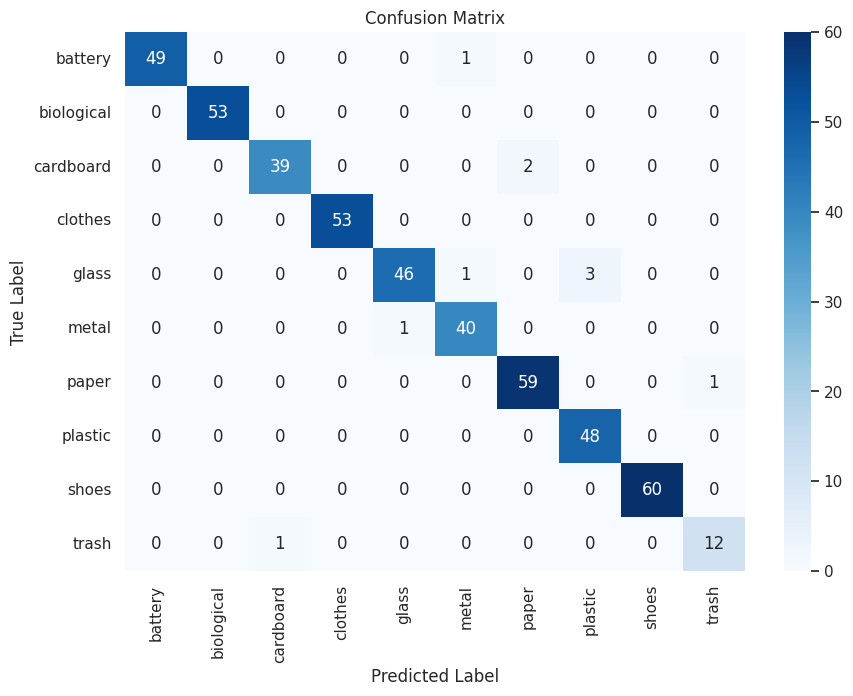

Confusion matrix saved as: /kaggle/working/confusion_matrix.png


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix

# ✅ Create Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_multi_input_generator.resnet_gen.class_indices.keys(),
            yticklabels=test_multi_input_generator.resnet_gen.class_indices.keys())

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")


# ✅ Save the image in Kaggle working directory
save_path = "/kaggle/working/confusion_matrix.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved as: {save_path}")

1/1 [==============================] - 0s 248ms/step


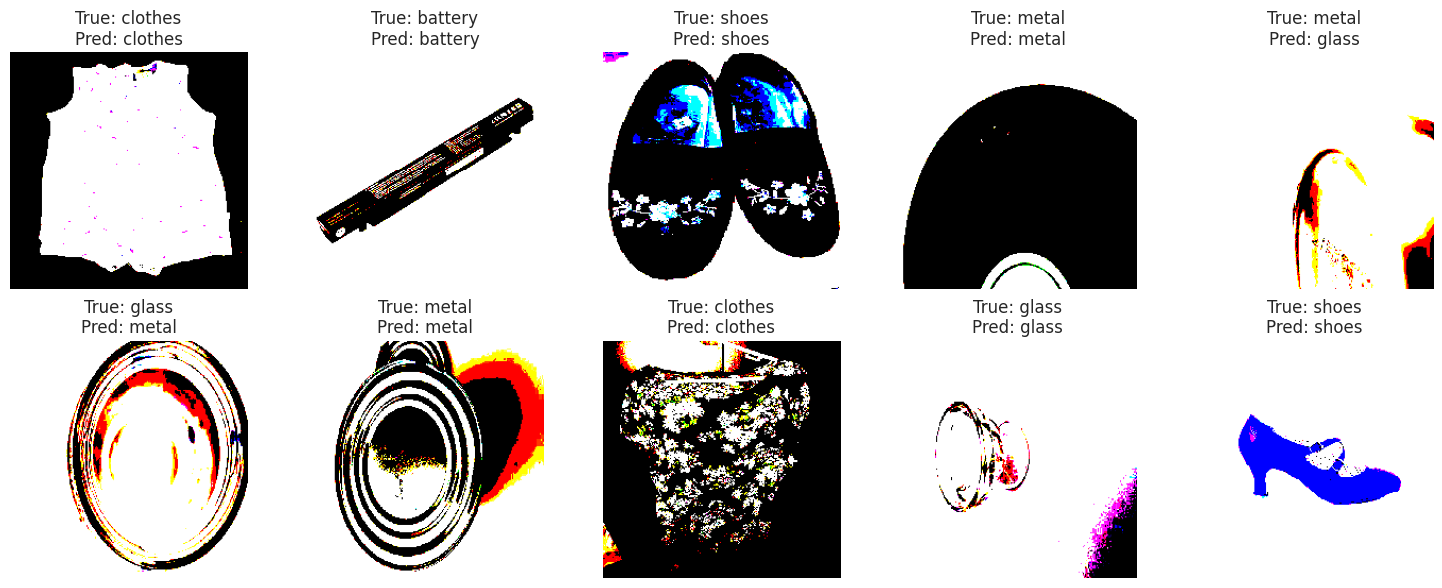

In [30]:
import random
import numpy as np
import matplotlib.pyplot as plt

# ✅ Select 10 random test indices
indices = random.sample(range(len(test_multi_input_generator)), 10)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# ✅ Get class names
class_names = list(test_multi_input_generator.resnet_gen.class_indices.keys())

for i, idx in enumerate(indices):
    # ✅ Extract multi-input batch
    (X_resnet, X_efficientnet, X_densenet), y_batch = test_multi_input_generator[idx]

    # ✅ Get first image from batch (only needed for visualization)
    img = X_resnet[0]  # Since images are the same for all inputs
    true_label = np.argmax(y_batch[0])  # True label index

    # ✅ Make prediction using all three inputs
    predicted_probs = hybrid_model.predict([
        np.expand_dims(X_resnet[0], axis=0),
        np.expand_dims(X_efficientnet[0], axis=0),
        np.expand_dims(X_densenet[0], axis=0)
    ])

    predicted_label = np.argmax(predicted_probs)  # Predicted label index

    # ✅ Display image with true vs predicted labels
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[predicted_label]}")
    ax.axis("off")

plt.tight_layout()
plt.show()